# Step 1: Load Data

In [1]:
import sys
import os
from transformers import AutoTokenizer
from pathlib import Path

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.dataset.scdnam_dataset import TokensRatiosDataset, scDNAm_collate_TokensRatios

tokenizer = AutoTokenizer.from_pretrained(f"../src/tokenizers/scdnam_6mer", trust_remote_code=True)
tumor_data = {}
tumor_data["tissue_test"] = TokensRatiosDataset(
    csv_file="tumor_detection/tissue_test_data/tissue.csv",
    root_path="tumor_detection/tissue_test_data/scWGBS_with_nucleotide_change_10mer_tokens_npz",
    K_mer="6mer", tokenizer=tokenizer, type_json_path="tumor_detection/tissue_test_data/tissue_type.json",
    need_labels=True,
    need_analysis=True,
    max_length = 20_000_000,  # Set to 12M (almost covered) CpGs for quick testing. A100 (80GB) handles 10M, H200 handles 20M. 
    random=False,
    use_sample=False,
    use_truncation=False,
    start_idx=0,
    selective_chrs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
)
tumor_data["cfDNA"] = TokensRatiosDataset(
    csv_file="tumor_detection/cfDNA_data/cfDNA.csv",
    root_path="tumor_detection/cfDNA_data/scWGBS_with_nucleotide_change_10mer_tokens_npz",
    K_mer="6mer", tokenizer=tokenizer, type_json_path="tumor_detection/cfDNA_data/cfDNA_type.json",
    need_labels=True,
    need_analysis=True,
    max_length = 20_000_000,  # Set to 12M (almost covered) CpGs for quick testing. A100 (80GB) handles 10M, H200 handles 20M. 
    random=False,
    use_sample=False,
    use_truncation=False,
    start_idx=0,
    selective_chrs=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],
)
data_collator = scDNAm_collate_TokensRatios(tokenizer=tokenizer)

output_dir = Path("output_dir")
output_dir.mkdir(parents=True, exist_ok=True)

/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tumor_data["tissue_test"][0]

{'unmethy_input_ids': array([  0,  11, 219, ..., 361, 141,   2]),
 'methy_input_ids': array([  0,  12, 220, ..., 362, 142,   2]),
 'methy_ratios': array([1., 0., 0., ..., 1., 1., 1.]),
 'positions': array([       0,    10609,    10617, ..., 51223989, 51223997,        0]),
 'chrs': array([ 0,  1,  1, ..., 22, 22,  0]),
 'file_names': 'GSM2697728_scTrioSeq2Met_CRC01_PT1_285.singleC.npz',
 'labels': 1}

In [3]:
tumor_data["cfDNA"][0]

{'unmethy_input_ids': array([  0,  11, 469, ..., 463, 177,   2]),
 'methy_input_ids': array([  0,  12, 470, ..., 464, 178,   2]),
 'methy_ratios': array([1.        , 0.72727275, 0.69999999, ..., 0.        , 0.        ,
        1.        ]),
 'positions': array([       0,    69486,    69495, ..., 51222384, 51222391,        0]),
 'chrs': array([ 0,  1,  1, ..., 22, 22,  0]),
 'file_names': 'GSM4502273_KRp2-18_bsmap_meth.npz',
 'labels': 5}

# Step 2: Load Model

In [4]:
from inference.inference import scDNAmGPTForAnalysis

model = scDNAmGPTForAnalysis.from_pretrained(
    tokenizer=tokenizer,
    pretrained_model_name="tumor_detection/model",
    num_labels=tumor_data["tissue_test"].num_labels,
    attention_mechanism={
      "projection_dim": 256,
      "attention_num_heads": 8,
      "dropout_rate": 0.1}
)

# Move model to device
device = "cuda:0"
model.to(device)  
model.eval() 

------------------------------------------
Shape of lm_head.weight:  torch.Size([520, 128]) 
------------------------------------------
[Missing keys]:
  - lm_head.weight


scDNAmGPTForAnalysis(
  (backbone): scDNAmMixerModel(
    (embedding): Embedding(520, 128)
    (layers): ModuleList(
      (0-7): 8 x Block(
        (norm): RMSNorm()
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
      )
    )
    (norm_f): RMSNorm()
  )
  (lm_head): Linear(in_features=128, out_features=520, bias=False)
  (query_proj): Linear(in_features=128, out_features=256, bias=True)
  (key_proj): Linear(in_features=128, out_features=256, bias=True)
  (value_proj): Linear(in_features=128, out_features=256, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuanti

# Step 3: Inference

In [5]:
from inference.inference import run_inference_on_dataset

for dataset_name, dataset in tumor_data.items():
    print(f"Running inference on {dataset_name} dataset...")
    run_inference_on_dataset(
        model, dataset, tokenizer, data_collator, 
        device, output_dir, dataset_name, 
        batch_size=1
    )

/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/scDNAm-GPT/inference/inference.py:308: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(), torch.no_grad():


Running inference on tissue_test dataset...


Inferencing: 100%|████████████████████| 59/59 [01:46<00:00,  1.80s/batch, current_samples=1/59, latest_file=GSM3153402...]
/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/scDNAm-GPT/inference/inference.py:308: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(), torch.no_grad():


Running inference on cfDNA dataset...


Inferencing: 100%|████████████████████| 54/54 [00:19<00:00,  2.73batch/s, current_samples=1/54, latest_file=GSM4502320...]


# Step 4: Embeddings

In [9]:
# === Minimal version: CSV -> array loading -> AnnData ===
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad


# ---------- Config ----------
CSV_PATH  = "output_dir/tissue_test/tissue_test_inference_results.csv"
DATA_DIR  = "output_dir/tissue_test/norm_attn_outputs"
FILTER_MATCHED = False  # If CSV has 'predictions' and you only want rows where labels==predictions, set True

# Numeric label -> text label
LABEL_MAP = {0: "Colorectal Normal Cell", 1: "Colorectal Tumor Cell"}

# ---------- Utilities ----------
def load_array(path: str):
    """Load .npz/.npy; if 2D+, reduce via axis=0 sum; convert sparse to dense; return 1D ndarray."""
    if not os.path.exists(path):
        return None
    try:
        obj = np.load(path, allow_pickle=True)
        if isinstance(obj, np.lib.npyio.NpzFile):
            key = "data" if "data" in obj.files else obj.files[0]
            arr = obj[key]
        else:
            arr = obj  # .npy is already an ndarray

        if sp.issparse(arr):
            arr = arr.toarray()

        if arr.ndim > 1:
            arr = arr.sum(axis=0)  # aggregate to a 1D feature vector across layers

        return np.asarray(arr).ravel()
    except Exception as e:
        print(f"[skip] {os.path.basename(path)} -> {e}")
        return None

def build_anndata(csv_path: str, data_dir: str, filter_matched: bool = False):
    df = pd.read_csv(csv_path)

    if filter_matched and {"labels", "predictions"}.issubset(df.columns):
        df = df[df["labels"] == df["predictions"]]

    X, obs_rows = [], []
    missing = 0

    for _, row in df.iterrows():
        file_name = row["file_name"]
        label_id = row["labels"]
        path = os.path.join(data_dir, file_name)

        arr = load_array(path)
        if arr is None:
            missing += 1
            continue

        X.append(arr)
        obs_rows.append({"file_name": file_name, "label_id": label_id})

    if not X:
        return None, {"n_rows": 0, "n_features": 0, "missing": missing}

    X = np.vstack(X)
    obs = pd.DataFrame(obs_rows)
    obs["cell_type"] = obs["label_id"].map(LABEL_MAP)

    adata = ad.AnnData(X=X, obs=obs[["file_name", "cell_type", "label_id"]])
    return adata, {"n_rows": X.shape[0], "n_features": X.shape[1], "missing": missing}

# ---------- Main ----------
adata, info = build_anndata(CSV_PATH, DATA_DIR, filter_matched=FILTER_MATCHED)

if adata is None or info["n_rows"] == 0:
    print("No matching data found. Cannot create AnnData.")
else:
    print(f"AnnData: {info['n_rows']} cells × {info['n_features']} features (skipped {info['missing']} missing/corrupted files)")
    # Optional save:
    adata.write(f"{output_dir}/tissue_test/tissue_test_data.h5ad")

AnnData: 59 cells × 256 features (skipped 0 missing/corrupted files)


/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
# === Minimal version: CSV -> array loading -> AnnData ===
import os
import numpy as np
import pandas as pd
import scipy.sparse as sp
import anndata as ad


# ---------- Config ----------
CSV_PATH  = "output_dir/cfDNA/cfDNA_inference_results.csv"
DATA_DIR  = "output_dir/cfDNA/norm_attn_outputs"
FILTER_MATCHED = False  # If CSV has 'predictions' and you only want rows where labels==predictions, set True

# Numeric label -> text label
LABEL_MAP = {0: "Normal Plasma", 1: "Colorectal Cancer Plasma", 2: "Colorectal Cancer Plasma", 
3: "Colorectal Cancer Plasma", 4: "Colorectal Cancer Plasma", 5: "Colorectal Cancer Plasma"}

# ---------- Utilities ----------
def load_array(path: str):
    """Load .npz/.npy; if 2D+, reduce via axis=0 sum; convert sparse to dense; return 1D ndarray."""
    if not os.path.exists(path):
        return None
    try:
        obj = np.load(path, allow_pickle=True)
        if isinstance(obj, np.lib.npyio.NpzFile):
            key = "data" if "data" in obj.files else obj.files[0]
            arr = obj[key]
        else:
            arr = obj  # .npy is already an ndarray

        if sp.issparse(arr):
            arr = arr.toarray()

        if arr.ndim > 1:
            arr = arr.sum(axis=0)  # aggregate to a 1D feature vector across layers

        return np.asarray(arr).ravel()
    except Exception as e:
        print(f"[skip] {os.path.basename(path)} -> {e}")
        return None

def build_anndata(csv_path: str, data_dir: str, filter_matched: bool = False):
    df = pd.read_csv(csv_path)

    if filter_matched and {"labels", "predictions"}.issubset(df.columns):
        df = df[df["labels"] == df["predictions"]]

    X, obs_rows = [], []
    missing = 0

    for _, row in df.iterrows():
        file_name = row["file_name"]
        label_id = row["labels"]
        path = os.path.join(data_dir, file_name)

        arr = load_array(path)
        if arr is None:
            missing += 1
            continue

        X.append(arr)
        obs_rows.append({"file_name": file_name, "label_id": label_id})

    if not X:
        return None, {"n_rows": 0, "n_features": 0, "missing": missing}

    X = np.vstack(X)
    obs = pd.DataFrame(obs_rows)
    obs["cell_type"] = obs["label_id"].map(LABEL_MAP)

    adata = ad.AnnData(X=X, obs=obs[["file_name", "cell_type", "label_id"]])
    return adata, {"n_rows": X.shape[0], "n_features": X.shape[1], "missing": missing}

# ---------- Main ----------
adata, info = build_anndata(CSV_PATH, DATA_DIR, filter_matched=FILTER_MATCHED)

if adata is None or info["n_rows"] == 0:
    print("No matching data found. Cannot create AnnData.")
else:
    print(f"AnnData: {info['n_rows']} cells × {info['n_features']} features (skipped {info['missing']} missing/corrupted files)")
    # Optional save:
    adata.write(f"{output_dir}/cfDNA/cfDNA_data.h5ad")

AnnData: 54 cells × 256 features (skipped 0 missing/corrupted files)


/mnt/shared-storage-user/ma4agi-gpu/liangchaoqi/miniconda3/envs/scDNAm_GPT/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


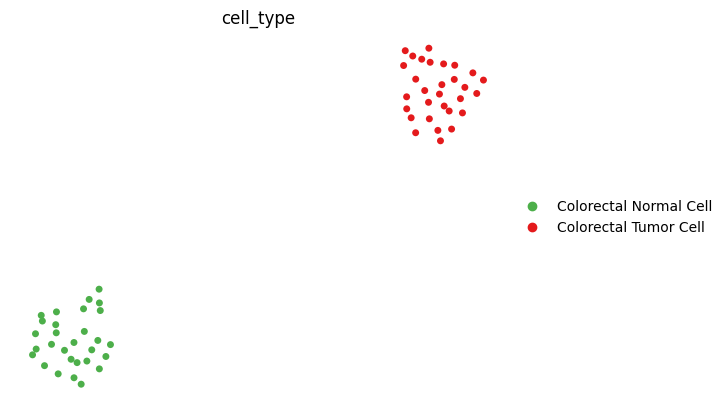

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Suppress verbose logging
sc.settings.verbosity = 0 

# Load h5ad file
adata = sc.read_h5ad(f"{output_dir}/tissue_test/tissue_test_data.h5ad")

# Run PCA -> compute neighbors -> UMAP
sc.pp.pca(adata, n_comps=20, random_state=42)
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=25, random_state=42)
sc.tl.umap(adata, random_state=42)

# Define palette
palette_colon = {
    "Colorectal Normal Cell": "#4daf4a",   # green
    "Colorectal Tumor Cell": "#e41a1c",    # red
}

# Fix category order (保证颜色和图例顺序一致)
adata.obs["cell_type"] = pd.Categorical(
    adata.obs["cell_type"],
    categories=["Colorectal Normal Cell", "Colorectal Tumor Cell"],
    ordered=True
)

# Plot UMAP with custom colors
sc.pl.umap(
    adata,
    color="cell_type",
    size=100,
    frameon=False,
    palette=palette_colon
)

plt.show()


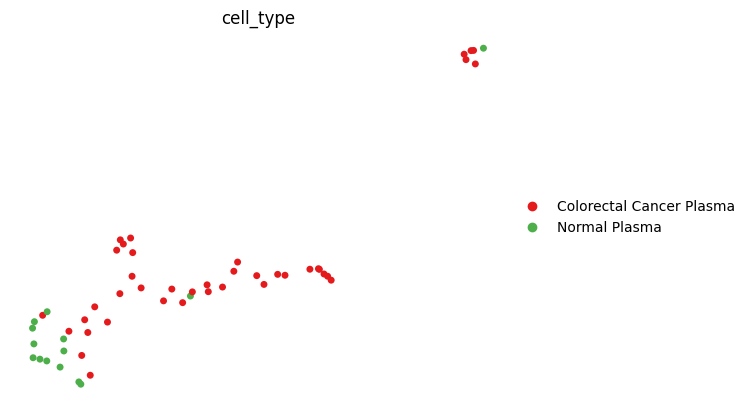

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt

# Suppress verbose logging
sc.settings.verbosity = 0 

# Load h5ad file
adata = sc.read_h5ad(f"{output_dir}/cfDNA/cfDNA_data.h5ad")

# Run PCA -> compute neighbors -> UMAP
sc.pp.pca(adata, n_comps=32, random_state=42)
sc.pp.neighbors(adata, n_pcs=32, n_neighbors=8, random_state=42)
sc.tl.umap(adata, min_dist=0.001, random_state=42)

# Define palette
palette_colon = {
    "Normal Plasma": "#4daf4a",   # green
    "Colorectal Cancer Plasma": "#e41a1c",    # red
}

# Plot UMAP with custom colors
sc.pl.umap(
    adata,
    color="cell_type",
    size=100,
    frameon=False,
    palette=palette_colon
)

plt.show()


# Step 5: Comparison

##### In the comparison of CRC tumor progression prediction, the Normal sample SRR11616089 was predicted by both MethylBERT and scDNAm-GPT to have a high risk of tumor progression. Since this result was inconsistent with its group label, scDNAm-GPT identified it as an outlier. To avoid the influence of this outlier on the baseline, the Normal Line was defined using the second-highest prediction value within the Normal group. Subsequently, the predictions from MethylBERT and scDNAm-GPT were scaled to the same numerical range to enable direct comparison.

#### MethylBERT

/tmp/ipykernel_1236031/1056596931.py:56: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x=y, y=predictions, hue=y, color='black', alpha=0.55, jitter=True, size=3, legend=False)


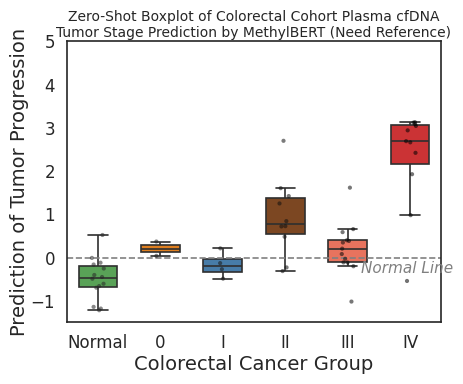

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

np.random.seed(42)  # Set global random seed

# Set Nature style
sns.set_theme(style='white')  # Remove grey background
plt.rcParams.update({
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.fontsize': 12,
    'pdf.fonttype': 42  # Prevent PDF font embedding issues
})

# Read data
df = pd.read_csv('tumor_detection/cfDNA_data/methylbert.csv', header=0, sep=',')

# Take the log of predictions (with a small constant to avoid log(0))
df['log_pred'] = np.log(df['pred'])

# Extract log_pred and label
X = df['log_pred'].values.reshape(-1, 1)
y = df['label'].values

# Scale for Comparison
w = 0.82665467
b = 4.221992007528449
X = X.ravel()
predictions = X * w + b

# Define custom color palette using numeric keys
palette = {
    0: '#4daf4a',  # Green
    1: '#ff7f00',  # Orange
    2: '#377eb8',  # Blue
    3: '#8b4513',  # Brown
    4: '#ff6347',  # Tomato (Orange-ish)
    5: '#e41a1c'   # Red
}

# Create the plot
plt.figure(figsize=(4.8, 4))

# Adjust width of boxplot for a narrower appearance
sns.boxplot(x=y, y=predictions, hue=y, palette=palette, fliersize=2.5, linewidth=1.2, showfliers=False, width=0.62, legend=False)
sns.stripplot(x=y, y=predictions, hue=y, color='black', alpha=0.55, jitter=True, size=3, legend=False)

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.text(x=4.22, y=-0.36, s='Normal Line', color='gray', fontsize=11, ha='left', fontstyle='italic')

# x-axis label mapping
label_mapping = {
    0: 'Normal',
    1: '0',
    2: 'I',
    3: 'II',
    4: 'III',
    5: 'IV'
}
plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()))

# Set axis labels and title
plt.xlabel('Colorectal Cancer Group', labelpad=2)
plt.ylabel('Prediction of Tumor Progression', labelpad=1)
plt.title('Zero-Shot Boxplot of Colorectal Cohort Plasma cfDNA\nTumor Stage Prediction by MethylBERT (Need Reference)', fontsize=10, pad=3)

plt.ylim(-1.5, 5)

# Add a full frame around the plot (box around the axes)
plt.gca().spines['top'].set_linewidth(1.2)
plt.gca().spines['right'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)
plt.gca().spines['left'].set_linewidth(1.2)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


#### scDNAm-GPT

/tmp/ipykernel_1236031/1339037932.py:56: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(x=y, y=predictions, hue=y, color='black', alpha=0.55, jitter=True, size=3, legend=False)


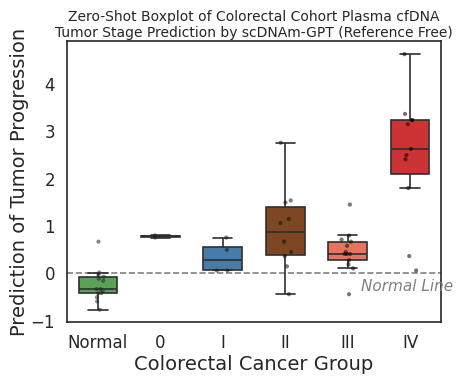

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit  # sigmoid function
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

np.random.seed(0)  # Set global random seed

# Set Nature style
sns.set_theme(style='white')  # Remove grey background
plt.rcParams.update({
    'font.size': 12,
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'legend.fontsize': 12,
    'pdf.fonttype': 42  # Prevent PDF font embedding issues
})

# Read data
df = pd.read_csv('output_dir/cfDNA/cfDNA_inference_results.csv')

# Process logits column, extract 2nd value and apply sigmoid
X = np.array([np.fromstring(p.strip('[]'), sep=' ')[1:2] for p in df['logits']])
y = df['labels'].values

# Scale for Comparison
w = 43.49703203
b = 54.8256735228019
X = X.ravel()
predictions = X * w + b

# Define custom color palette using numeric keys
palette = {
    0: '#4daf4a',  # Green
    1: '#ff7f00',  # Orange
    2: '#377eb8',  # Blue
    3: '#8b4513',  # Brown
    4: '#ff6347',  # Tomato (Orange-ish)
    5: '#e41a1c'   # Red
}

# Create the plot
plt.figure(figsize=(4.8, 4))
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.2)
plt.text(x=4.22, y=-0.36, s='Normal Line', color='gray', fontsize=11, ha='left', fontstyle='italic')

# Adjust width of boxplot for a narrower appearance
sns.boxplot(x=y, y=predictions, hue=y, palette=palette, fliersize=2.5, linewidth=1.2, showfliers=False, width=0.62, legend=False)
sns.stripplot(x=y, y=predictions, hue=y, color='black', alpha=0.55, jitter=True, size=3, legend=False)

# x-axis label mapping
label_mapping = {
    0: 'Normal',
    1: '0',
    2: 'I',
    3: 'II',
    4: 'III',
    5: 'IV'
}
plt.xticks(ticks=list(label_mapping.keys()), labels=list(label_mapping.values()))

# Set labels and title
plt.xlabel('Colorectal Cancer Group', labelpad=2)
plt.ylabel('Prediction of Tumor Progression', labelpad=1)
plt.title('Zero-Shot Boxplot of Colorectal Cohort Plasma cfDNA\nTumor Stage Prediction by scDNAm-GPT (Reference Free)', fontsize=10, pad=3)

# plt.ylim(-1.5, 5)
# sns.despine()

# Add a full frame around the plot (box around the axes)
plt.gca().spines['top'].set_linewidth(1.2)
plt.gca().spines['right'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)
plt.gca().spines['left'].set_linewidth(1.2)

plt.tight_layout()
plt.show()
